 # Deep Autoencoder(Stack Autoencoder) - Redução de dimensionalidade

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import models, layers, datasets, utils, preprocessing

%matplotlib inline

## Obter os dados

In [2]:
# A base de dados já está dividida em dois conjuntos: treino e teste
# Como vai-se apenas fazer a redução da dimensionalidade não é necessária avariavel de saida. E o autoencoder é um algoritmo
# não supervisionado, por isso é utilizado normalmente quando não se tem acesso a esses dados. Mas tambem não se deveria dividir
# o dataset emtreino e teste.
# Coloca-se _ para que essa variavel não seja criada
(X_train, _), (X_test, _) = datasets.mnist.load_data()

In [3]:
# 60000 imagens para treino
len(X_train)

60000

In [4]:
# 10000 imagens para teste
len(X_test)

10000

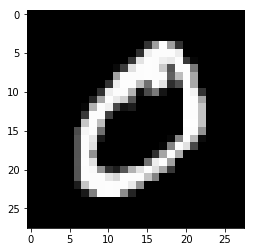

In [5]:
# Número zero a preto e branco
plt.imshow(X_train[1], cmap="gray")

In [6]:
# Matriz com os pixeis da imagem com o número zero.
# Matriz 28x28 (784 pixeis).
pixeis = X_train[1]
pixeis.shape

(28, 28)

# Pré-Processamento dos dados

In [7]:
# 60000 imagens para treino
X_train.shape[0]

60000

### Transformar os dados num vector em que o tensorflow consiga fazer a sua leitura.

In [8]:
# Para redes neurais convolucionais:
# 1º parametro: número de imagens
# 2º parametro: Altura da imagem (nº de pixeis da imagem na vertical).
# 3º parametro: Largura da imagem (nº de pixeis da imagem na horizontal).

# Nº de canais de RGB: Como a cor não tem influência neste caso pode-se utilizar a imagem a preto e branco(rgb=1). Quando se 
# utilizam as imagens a cores (rgb=3) o algoritmo fica mais lento porque aumenta a dimensionalidade dos dados. Uma imagem a 
# cores tem 3 canais(valores) dentro de cada pixel, porque o pixel é subdividio em vermelho(r), verde(g e azul(b)). Com rgb=1 
# tem-se menos dados para processar.

# A escala de cinzento possui apenas um canal. Quanto mais próximo de 255 mais claro é o cinzento e quanto mais próximo de 
# 0 mais escura é a cor.
# Nesta escala o Pixel com o valor 255 é o branco e pixel 0 é o preto. Ao redor do número tem-se apenas o valor 0, que indica o 
# preto(o fundo é preto).

#X_train = X_train.reshape(X_train.shape[0], 28, 28, 1) # (60000, 28, 28, 1)
#X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
#-------------------------------------------------------------------------------------------------------------------
# Para redes neurais artificiais:
# 1º parametro: número de imagens.
# 2º parametro: quantidade de pixeis por imagem. Neste caso tem-se 28x28=784 pixeis.

X_train = X_train.reshape((len(X_train), np.prod(X_test.shape[1:]))) # (60000, 784)
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

In [9]:
X_train.shape

(60000, 784)

### Conversão dos dados do tipo int8 para float32

In [10]:
# Como os dados vão ser convertidos para uma escala entre 0 e 1 tem-se de converter os dados de inteiro8 para float32 para que
# os valores obtidos depois da normalização não sejam inteiros e consequentemente quase todos 0(por não haver números decimais).

#X_test[0,1,1]
type(X_test[0,1])

numpy.uint8

In [11]:
# Conversão dos dados em float 32
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

In [12]:
type(X_test[0,1])

numpy.float32

### Normalização dos pixeis

In [13]:
# passar os pixeis para uma escala de 0 a 1 para que o precessamento dos dados seja mais rapido
# Isto pode ser feito através da tecnica min max normalization. Como cada pixel ocupa 1 byte e o byte consegue guardar 256
# resultados possiveis(ou seja varia entre 0 e 255). 
# A normalização pode ser feita dividindo o pixel por 255 (tambem se podia utilizar o skit-learn).

# Pode-se ver que o valor máximo de um pixel é de 255
X_test[0].max()

255.0

In [14]:
X_test[0].min()

0.0

In [15]:
# Normalização do conjunto de teste e treino
X_train = X_train/255
X_test = X_test/255

In [16]:
X_test[0].max()

1.0

## Modelo Deep Autoencoder

In [17]:
# factor de compactação = 784/32 = 24.5.Vai-se compactar a imagem 24.5 vezes em relação à original.

# Sequential - A informação move-se da camada de entrada, para a camada oculta e de seguida para a camada de saida.

#Dense - Camadas densas(cada um dos neurónios é ligado com todos os neuronios da camada seguinte) tambem chamada de rede neural
# fully connected

# 1ª Camada Oculta(e definição da camada de entrada) 
# units: Número de neuronios da 1ª camada oculta. Definir qual a redução de dimensionalidade que se quer na 1º camada oculta.
# Neste caso pretende-se passar de 784 variaveis de entrada para 128 na 1º camada oculta.
# Função de Activação: Normalmente escolhe-se a reLu para deep learning porque obtem-se melhores resultados do que com uma
# função sigmoide ou tangente hiperbolica. 
# Kernel initializer: Como se inicializam os pesos.
# input_dim: quantos atributos existem na camada de entrada (neste caso são 784 variaveis de entrada). Este parâmetro só é 
# necessário para a primeira camada oculta. Com este parâmetro activo não é necessário colocar explicitamente a camada de 
# entrada porque na 1ª camada oculta está-se a dizer o numero de neurónios da camada de entrada.

# Camada de Saida
# units: Número de neurónios da camada de saida. Igual ao número de neurónios da camada de entrada.
# Função de activação: Sigmoid porque é um problema de classificação binário que varia entre 0 e 1, e esta função retorna sempre
# um valor entre 0 e 1. Pode-se utilizar a sigmoid porque foi feita a normalização dos pixeis entre 0 e 1. Tambem se utiliza
# bastantes vezes a função sigmoid.

#------------------------------------------------------------------------------------------------------------------------
# Predende-se reduzir a dimensionalidade de 784 para 32.
# Na codificação(encode):
# Tem-se a camada de entrada com 784 neurónios
# Tem-se de seguida uma camada oculta com 128 neurónios.
# Tem-se de seguida uma camada oculta com 64 neurónios.
# Tem-se de seguida uma camada oculta com 32 neurónios. A camada com a redução da dimensionalidade pretendida.
# Na descodificação(decode):
# Tem-se de seguida uma camada oculta com 64 neurónios.
# Tem-se de seguida uma camada oculta com 128 neurónios.
# Tem-se a camada de saida com 784 neurónios. Dimensão original(da camada de entrada).

model = models.Sequential()
model.add(layers.Dense(units=128, activation="relu", input_dim=784)) # 1º Camada oculta e definição da camada de entrada. 
model.add(layers.Dense(units=64, activation="relu"))
model.add(layers.Dense(units=32, activation="relu")) # 3º camada oculta (camada com a redução de dimensionalidade pretendida).
model.add(layers.Dense(units=64, activation="relu"))
model.add(layers.Dense(units=128, activation="relu"))
model.add(layers.Dense(units=784, activation="sigmoid")) # Camada de Saida.

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_5 (Dense)              (None, 784)               101136    
Total params: 222,384
Trainable params: 222,384
Non-trainable params: 0
__________________________________________________

## Compilação e Ajuste do modelo autoencoder

In [20]:
# Optimizer: adam é uma optimização da descida do gradiente estócastico (usado para encontrar os melhores valores dos pesos).
# É o que melhor se adapta à maioria dos casos.

# loss = função de perda binary_crossentropy é a mais utilizada para classificação binária. Mede o quão afastada está a previsão
# do seu valor real(0 ou 1) para cada classe e faz a média desses erros(desvios) para obter o custo(loss). Como utiliza o
# logaritmo tem uma penalização maior quando existe uma classificação errada.

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["binary_accuracy"])

In [21]:
# batch_size
# batch_size: 256, calcula-se o erro de um conjunto de 256 dados e actualizam-se os pesos. Quanto mais alto este valor, mais
# rapido são executados os calculos.

# epochs: Quantas vezes o algoritmo percorre o conjunto de dados de treino totalmente.

# 1ª epoca- calcula o erro para os primeiros 256 dados e actualiza todos os pesos. calcula o o erro para os 256 dados seguintes 
# e actualiza todos os pesos. E assim sucessivamente.
# 2ª epoca- calcula o erro para os primeiros 256 dados(com os pesos da 1ª epoca) e actualiza os pesos. calcula o erro para 
# os 256 dados seguintes e actualiza todos os pesos. E assim sucessivamente.

# Validation data: Avaliação do modelo utilizando a base de dados de teste (val_accuracy).

# Em vez do y_train utiliza-se o X_train em seu lugar. 
# Está-se a fazer a codificação da camada de entrada no nº de neurónios da camada oculta.
# De seguida faz-se a descodificação da camada oculta na camada de saida.
# De seguida compara-se a camada de saida com a camada de entrada(e não com o y_train).
# Calcula-se o erro e ajustam-se os pesos utilizando a tecnica back-propagation.
# Repetem-se os passos anteriores para o número de épocas definido.

# Ajustar os dados de entrada de treino aos dados de saida de treino para treinar o modelo
model.fit(X_train, X_train, batch_size=256, epochs=50, validation_data=(X_test,X_test))

W0719 14:06:49.728980 10068 deprecation.py:323] From C:\Users\Bruno\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 6s 92us/sample - loss: 0.2509 - binary_accuracy: 0.7836 - val_loss: 0.1682 - val_binary_accuracy: 0.8010
Epoch 2/50
60000/60000 [==============================] - 6s 97us/sample - loss: 0.1499 - binary_accuracy: 0.8053 - val_loss: 0.1344 - val_binary_accuracy: 0.8065
Epoch 3/50
60000/60000 [==============================] - 6s 93us/sample - loss: 0.1302 - binary_accuracy: 0.8088 - val_loss: 0.1235 - val_binary_accuracy: 0.8089
Epoch 4/50
60000/60000 [==============================] - 6s 105us/sample - loss: 0.1211 - binary_accuracy: 0.8102 - val_loss: 0.1170 - val_binary_accuracy: 0.8091
Epoch 5/50
60000/60000 [==============================] - 6s 98us/sample - loss: 0.1158 - binary_accuracy: 0.8111 - val_loss: 0.1125 - val_binary_accuracy: 0.8106
Epoch 6/50
60000/60000 [==============================] - 6s 93us/sample - loss: 0.1121 - binary_accuracy: 0.8116 - val_loss: 0.1089 -

## Modelo Deep Autoencoder para redução da dimensionalidade

In [35]:
# original size: Camada de entrada com as dimensões originais da imagem.
# encoded size_final: Camada com a redução da dimensionalidade aplicada através da codificação(camada zero do modelo do 
# autoencoder).

original_size = layers.Input(shape=784,)
encoded_size_1 = layers.Dense(units=128, activation="relu", input_dim=784)
encoded_size_2 = layers.Dense(units=64, activation="relu")
encoded_size_final = layers.Dense(units=32, activation="relu")

# Tambem se pode utilizar:
#encoded_size_1 = model.layers[0] 
#encoded_size_2 = model.layers[1] 
#encoded_size_final = model.layers[2] 

In [36]:
# Com o modelo de autoencoder model fez-se a codificação e descodificação. Ou seja reduziu-se a dimensionalidade das imagens e
# depois voltou a transformar-se as imagens na dimensão original.
# Com o modelo encoder apenas se faz a codificação. Ou seja apenas se reduz a dimensionalidade das imagens.

# Modelo para fazer a redução de dimensionalidade.

# Model utiliza-se quando se quer criar manualmente a rede neural.
# O modelo encoder recebe o original_size e transforma no encoded_size.

# Model(camada de entrada, estrutura da rede).
# A camada encoded_size_final segue-se à camada encoded_size_2, à camada encoded_size_1 e à camada original_size.
encoder = models.Model(original_size,
                       encoded_size_final(encoded_size_2(encoded_size_1(original_size)))) 

In [38]:
# Transforma de 784 dimensões para 32 dimensões.
encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_19 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_20 (Dense)             (None, 32)                2080      
Total params: 110,816
Trainable params: 110,816
Non-trainable params: 0
_________________________________________________________________


In [43]:
# Imagens de teste codificadas(com redução de dimensionalidade de 784 para 32).
X_test_codificado = encoder.predict(X_test)
X_test_codificado[0].shape

(32,)

In [44]:
# Imagens de teste descodificadas(com a dimensionalidade original de 784).
X_test_descodificado = model.predict(X_test)
X_test_descodificado[0].shape

(784,)

## Visualização das imagens

In [41]:
# Escolher um numero_imagens aleatorias do conjunto de teste.
# X_test.shape[0]: número de total de imagens no conjunto de teste.
# size: número de imagens que se quer escolher aleatoriamente.
numero_imagens = 10
imagens_teste = np.random.randint(X_test.shape[0], size=numero_imagens)

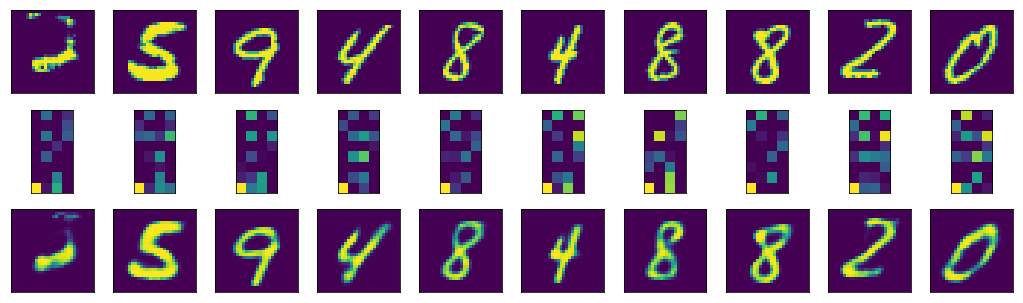

In [42]:
plt.figure(figsize=(18,18))

for i, indice_imagens in enumerate(imagens_teste):
    #print(i)
    #print(indice_imagens)
    
     # imagem original
    eixo = plt.subplot(10,10,i + 1)
    plt.imshow(X_test[indice_imagens].reshape(28,28)) #(28,28) tamanho da imagem original
    plt.xticks(())
    plt.yticks(())
    
    # imagem codificada
    eixo = plt.subplot(10,10,i + 1 + numero_imagens)
    plt.imshow(X_test_codificado[indice_imagens].reshape(8,4)) #(8,4)=32 Pode ser um dos tamanhos escolhidos para a imagem codificada
    plt.xticks(())
    plt.yticks(())
    
     # imagem reconstruída(codificada e depois descodificada)
    eixo = plt.subplot(10,10,i + 1 + numero_imagens * 2)
    plt.imshow(X_test_descodificado[indice_imagens].reshape(28,28)) #(28,28) tamanho da imagem original. Aumentando o
    # número de epocas as imagens reconstruidas vão aproximar-se das imagens originais.
    plt.xticks(())
    plt.yticks(())